In [1]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [3]:
import pandas as pd

In [4]:
query="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 34
"""

In [5]:
df = pd.read_sql(query, conn)

/var/folders/vt/5wzq72vd2mj_qqq_fwp77h_40000gq/T/ipykernel_8198/1168034203.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


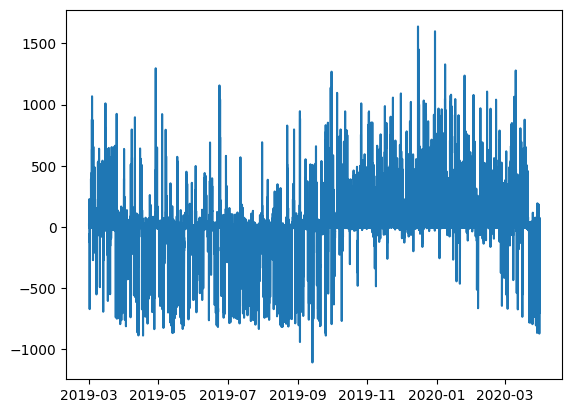

In [6]:
#plot 
import matplotlib.pyplot as plt
plt.plot(df.ts, df.net_load)
plt.show()


In [7]:
#check stationarity using ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.net_load)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#print if its stationary or not
if result[1] > 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

ADF Statistic: -29.950485
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Series is Stationary


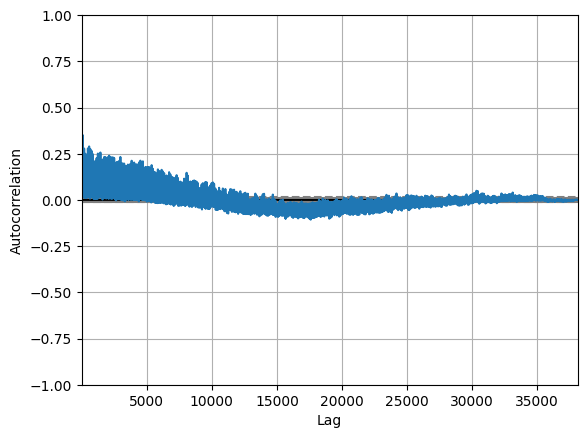

In [8]:
#plot the autocorrelation for different lags
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.net_load)
plt.show()

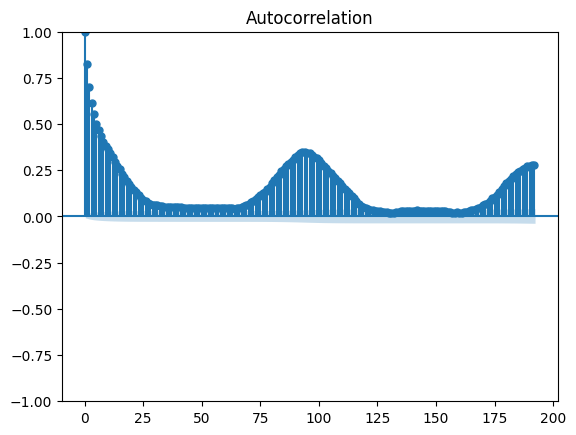

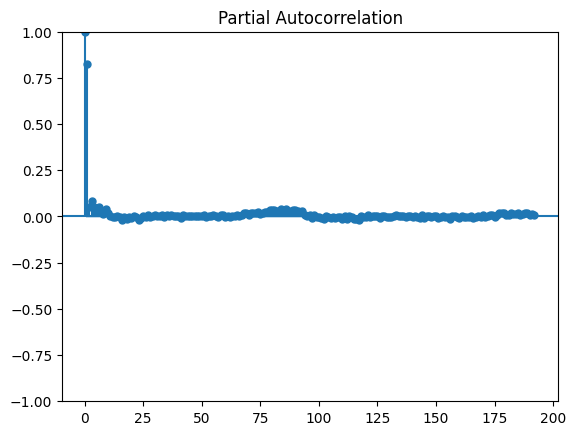

In [9]:
# plot the ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.net_load, lags=4*24*2)
plt.show()
plot_pacf(df.net_load, lags=4*24*2)
plt.show()

In [11]:
# fit an arima model and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from itertools import product
register_matplotlib_converters()

In [12]:
# leave the last n samples for testing
n = 24*4
train = df.net_load[:-n]
test = df.net_load[-n:]

In [13]:
# Fit the ARIMA model
model = ARIMA(train, order=(2,0,0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=n)


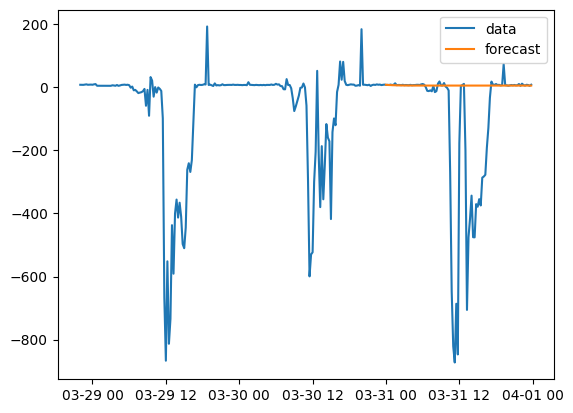

In [14]:
# Plot the forecast n*3 data before and the test data
plt.plot(df.ts[-n*3:], df.net_load[-n*3:], label='data')
plt.plot(df.ts[-n:], predictions, label='forecast')
plt.legend()
plt.show()

In [16]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               net_load   No. Observations:                38004
Model:                 ARIMA(2, 0, 0)   Log Likelihood             -228731.492
Date:                Tue, 19 Mar 2024   AIC                         457470.984
Time:                        01:10:27   BIC                         457505.166
Sample:                             0   HQIC                        457481.830
                              - 38004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6361      3.205      1.759      0.079      -0.645      11.918
ar.L1          0.7844      0.002    353.485      0.000       0.780       0.789
ar.L2          0.0499      0.002     21.377      0.000       0.045       0.055
sigma2      9890.9672     22.272    444.101      0.000    9847.315    9934.619
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):            631151.57
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

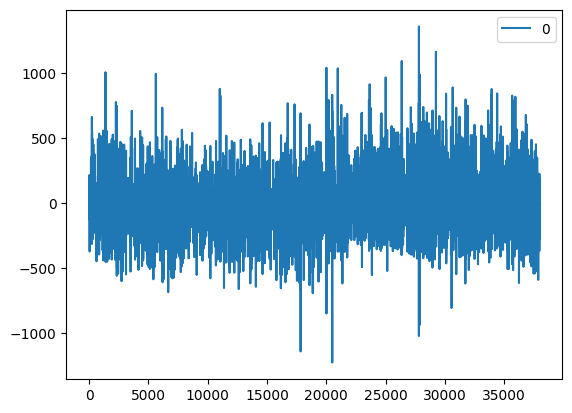

,0
count,38004.000000
mean,0.000057
std,99.452079
min,-1226.622787
25%,-6.255318
50%,-0.080419
75%,5.894770
max,1361.423682


In [15]:
# show the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# calculate the expected value of the residuals
residuals.describe()

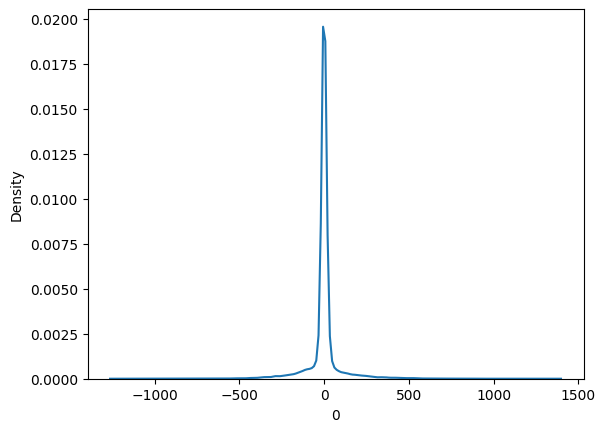

In [16]:
# plot distribution of residuals using a kdensity plot
import seaborn as sns
sns.kdeplot(residuals[0])
plt.show()

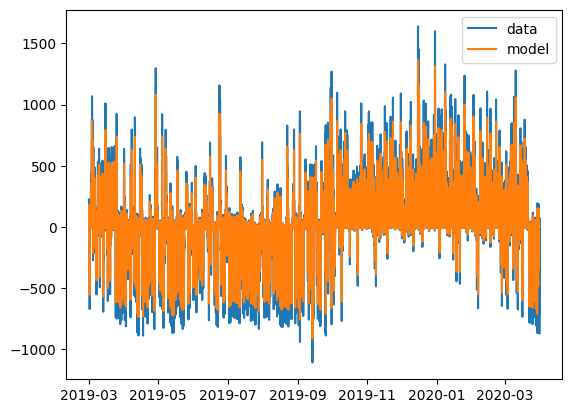

In [17]:
#plot the model vs the data
plt.plot(df.ts, df.net_load, label='data')
plt.plot(df.ts, pd.concat([model_fit.fittedvalues, predictions]), label='model')
plt.legend()
plt.show()

## Auto ARIMA

In [21]:
import pmdarima as pm

In [28]:
autoarima = pm.auto_arima(train[0:2000], seasonal=True, m=n, stepwise=True, trace=True, stationary=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[96] intercept   : AIC=inf, Time=196.90 sec
 ARIMA(0,0,0)(0,0,0)[96] intercept   : AIC=25537.168, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[96] intercept   : AIC=24091.401, Time=22.09 sec
 ARIMA(0,0,1)(0,0,1)[96] intercept   : AIC=24610.150, Time=62.95 sec
 ARIMA(0,0,0)(0,0,0)[96]             : AIC=25729.581, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[96] intercept   : AIC=24089.514, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[96] intercept   : AIC=24091.399, Time=19.86 sec
 ARIMA(1,0,0)(1,0,1)[96] intercept   : AIC=24093.399, Time=46.99 sec
 ARIMA(2,0,0)(0,0,0)[96] intercept   : AIC=24079.006, Time=0.07 sec
 ARIMA(2,0,0)(1,0,0)[96] intercept   : AIC=24080.729, Time=36.50 sec
 ARIMA(2,0,0)(0,0,1)[96] intercept   : AIC=24080.726, Time=28.74 sec
 ARIMA(2,0,0)(1,0,1)[96] intercept   : AIC=24082.726, Time=52.21 sec
 ARIMA(3,0,0)(0,0,0)[96] intercept   : AIC=24056.810, Time=0.10 sec
 ARIMA(3,0,0)(1,0,0)[96] intercept   : AIC=24058.721, Time=43.92 sec
 

KeyboardInterrupt: 

In [26]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -3035.419
Date:                Tue, 19 Mar 2024   AIC                           6080.837
Time:                        01:56:46   BIC                           6101.900
Sample:                             0   HQIC                          6089.103
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8580      0.039     21.938      0.000       0.781       0.935
ma.L1         -1.1989      0.047    -25.461      0.000      -1.291      -1.107
ma.L2          0.1250      0.042      2.954      0.003       0.042       0.208
ma.L3          0.0812      0.040      2.054      0.040       0.004       0.159
sigma2      1.121e+04    338.961     33.082      0.000    1.05e+04    1.19e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2514.13
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             2.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX

In [18]:
# import sarima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [22]:
model = SARIMAX(train, order=(4, 0, 0), seasonal_order=(2, 0, 0, n))
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05464D+00    |proj g|=  1.67548D-01


 This problem is unconstrained.



At iterate    5    f=  6.01232D+00    |proj g|=  5.79825D-04


: 

In [20]:
predictions = model_fit.forecast(steps=n)

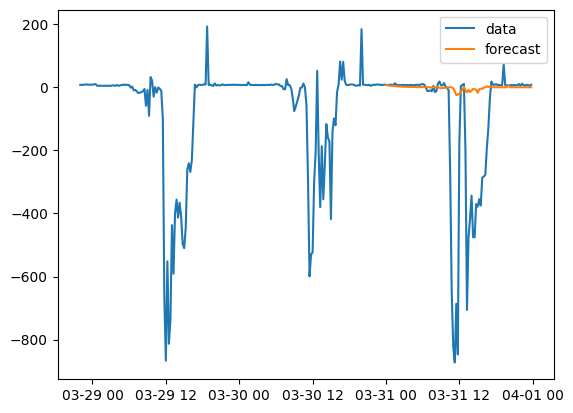

In [21]:
# Plot the forecast n*3 data before and the test data
plt.plot(df.ts[-n*3:], df.net_load[-n*3:], label='data')
plt.plot(df.ts[-n:], predictions, label='forecast')
plt.legend()
plt.show()